**0. Описание задачи**

На основании данных о пользователях и их активности в приложении, необходимо предсказать статус пользователя ( retained или churned)
* ID - идентификатор
* label - статус ползоваиеля
* sessions - число открытий приложения в течение месяца
* drives - количество поездок не менее 1 км за месяц
* total_sessions - всего сессий за время наблюдения
* n_days_after_onboarding - количество дней после регистрации
* total_navigations_fav1 - общее количество переходов с момента регистрации на любимом месте пользователя: 1
* total_navigations_fav2 - общее количество переходов с момента регистрации на любимом месте пользователя: 2
* driven_km_drives - общее количество пройденных километров за месяц
* duration_minutes_drives - общая продолжительность вождения в минутах в течение месяца
* activity_days - количество дней в месяц, когда пользователь открывает приложение
* driving_days - количество дней, когда пользователь совершает поездки (не менее 1 км) в течение месяца
* device - тип устройства, с которого пользователь начинает сеанс

**1. Чение данных**

In [ ]:
!pip install ace-tools-open

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.2 MB/s eta 0:00:00


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("joaofilipemarques/google-advanced-data-analytics-waze-user-data")

print("Path to dataset files:", path)

100%|██████████| 475k/475k [00:00<00:00, 880kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/joaofilipemarques/google-advanced-data-analytics-waze-user-data/versions/1


**2. Визуализация данных и подсчет основных параметров**

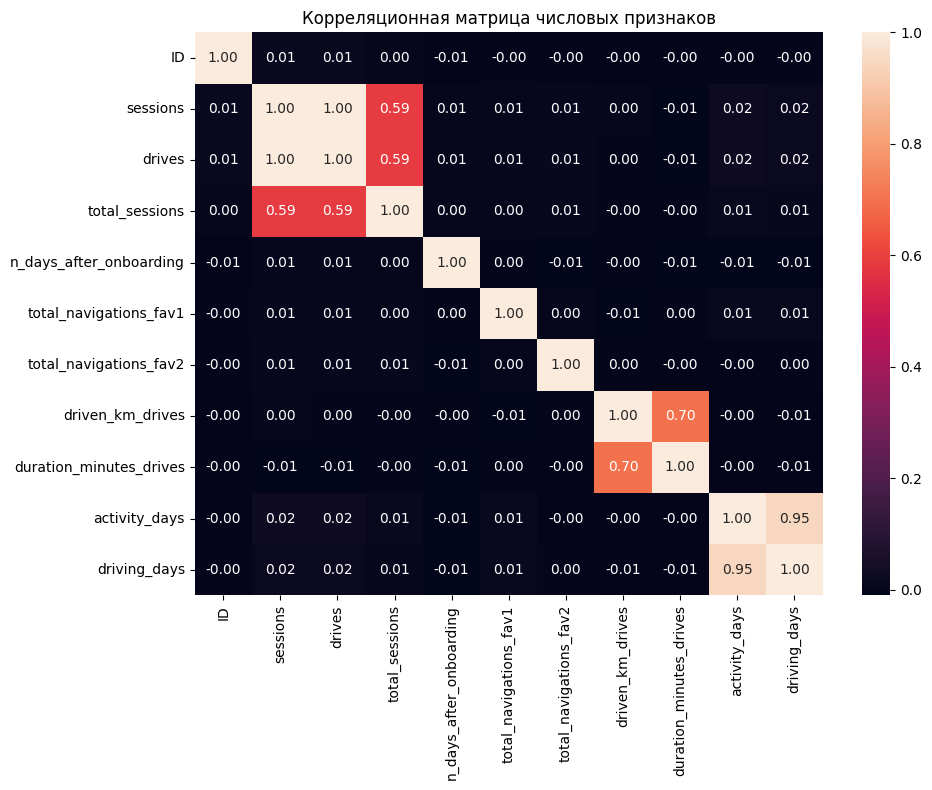

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = pd.read_csv("sample_data/waze_dataset.csv")
data_describe = data.describe()
data_cleaned_corr = data.drop(columns=['label', 'device'])
correlation_matrix = data_cleaned_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Корреляционная матрица')
plt.tight_layout()

сильная корелляция:

* driven_k_drives - duration_minutes_drives
* activity_days - driving_days
* drives - sessions
* sessions - total sessions
* total_sessions - drives



**3. Обработка пропущенных значений**

In [ ]:
missing_values = data.isnull().sum()
missing_label_count = missing_values['label']
missing_values, missing_label_count

(ID                           0
 label                      700
 sessions                     0
 drives                       0
 total_sessions               0
 n_days_after_onboarding      0
 total_navigations_fav1       0
 total_navigations_fav2       0
 driven_km_drives             0
 duration_minutes_drives      0
 activity_days                0
 driving_days                 0
 device                       0
 dtype: int64,
 700)

в свойстве label всего 700 пропущенных значений, удалим их.

In [ ]:
data_cleaned = data.dropna(subset=['label'])

new_shape = data_cleaned.shape
new_shape

(14299, 13)

в новой таблице 14299 столбцов

**4. Обработка категориалных признаков**

<Figure size 1000x800 with 0 Axes>

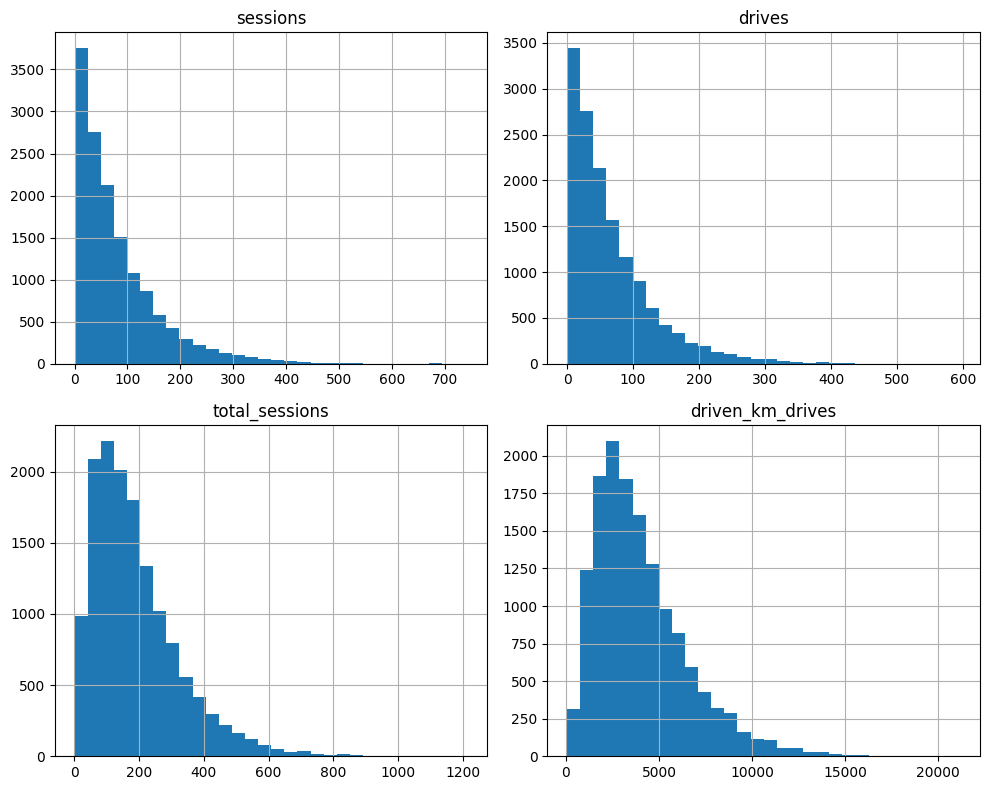

In [ ]:
data_encoded = pd.get_dummies(data_cleaned, columns=['device'], drop_first=True)
plt.figure(figsize=(10, 8))
data_encoded[['sessions', 'drives', 'total_sessions', 'driven_km_drives']].hist(bins=30, layout=(2, 2), figsize=(10, 8))
plt.tight_layout()
plt.show()

**5. Нормализация данных**

Перед тем, как исползовать классификатор knn необходимо нормализовать данные,
т.к. knn чувствителен к масштабированию данных

In [ ]:
from sklearn.preprocessing import StandardScaler
data_for_scaling = data_encoded.copy()
numeric_features = [
    'sessions', 'drives', 'total_sessions', 'n_days_after_onboarding',
    'total_navigations_fav1', 'total_navigations_fav2', 'driven_km_drives',
    'duration_minutes_drives', 'activity_days', 'driving_days'
]

scaler = StandardScaler()
data_for_scaling[numeric_features] = scaler.fit_transform(
    data_for_scaling[numeric_features])

**6. Разбиение на обучающую и тестовую выборки**

In [ ]:
from sklearn.model_selection import train_test_split

X = data_for_scaling.drop(['ID', 'label'], axis=1)
y = data_for_scaling['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)
split_shapes = (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

**7. Классификация с помощю KNN**

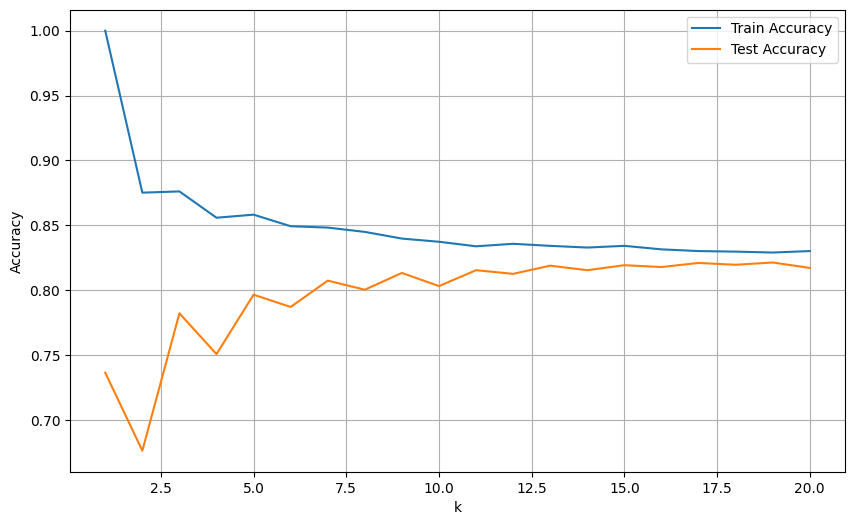

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np

k_values = range(1, 21)
train_accuracies = []
test_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_accuracy = accuracy_score(y_train, knn.predict(X_train))
    test_accuracy = accuracy_score(y_test, knn.predict(X_test))
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies, label='Train Accuracy')
plt.plot(k_values, test_accuracies, label='Test Accuracy')
plt.title(' График зависимости точности от k')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


**8. Вычислить ошибки на обучающей и тестовой выборках. Выбрать оптимальное значение гиперпараметра**

In [ ]:
import numpy as np
optimal_k = k_values[np.argmax(test_accuracies)]
optimal_accuracy = max(test_accuracies)
optimal_k, optimal_accuracy

(19, 0.8213286713286714)

Оптималное значение k - 19.

Обучение KNN с оптималным занчением k

In [35]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
knn_optimal.fit(X_train, y_train)
train_accuracy_optimal = accuracy_score(y_train, knn_optimal.predict(X_train))
test_accuracy_optimal = accuracy_score(y_test, knn_optimal.predict(X_test))

* оптимальная точность тренировочной выборки - 83%
* оптимальная точность тестовой выборки - 82%

**9. Общие выводы**

Общие выводы:При оптимальном значении k модель KNN показывает небольшой уровень ошибки на тестовой выборке - 82%. Оптимальное значение k - 19.